# Graph Learning

## Lab 7: Graph Neural Networks

In this lab, you will learn to classify nodes using a graph neural network (GNN).

## Import

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
from sknetwork.classification import get_accuracy_score
from sknetwork.data import load_netset
from sknetwork.embedding import Spectral
from sknetwork.gnn import GNNClassifier
from sknetwork.utils import directed2undirected
from sklearn import metrics

from sklearn.manifold import TSNE

## Data

We will work on the following datasets (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Cora (directed graph + bipartite graph)
* WikiVitals (directed graph + bipartite graph)

Both datasets are graphs with node features (given by the bipartite graph) and ground-truth labels.

In [3]:
cora = load_netset('cora')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


In [4]:
def visualize_embedding(embedding, labels, size=(6,6)):
    """Visualize embedding in 2 dimensions using TSNE. """
    print("Computing TSNE...")
    tsne = TSNE(random_state=8).fit_transform(embedding)
    fig, ax = plt.subplots(1, 1, figsize=size)
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, s=50, cmap='hsv')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## 1. Cora

We start with the Cora dataset. We check the embedding of the nodes before and after learning, and the impact of the GNN architecture on accuracy.

In [5]:
dataset = cora

In [6]:
adjacency = dataset.adjacency
features = dataset.biadjacency
labels_true = dataset.labels

In [7]:
# we use undirected graphs
adjacency = directed2undirected(adjacency)

## To do

Consider a GNN with a single hidden layer of dimension 16.

* Run a single forward pass on the data, without learning.
* Display the embedding provided by the hidden layer.

In [8]:
hidden_dim = 16

In [9]:
n_labels = len(set(labels_true))

In [10]:
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)

In [11]:
gnn

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [12]:
output = gnn.forward(adjacency, features)

In [13]:
embedding = gnn.layers[0].embedding

Computing TSNE...


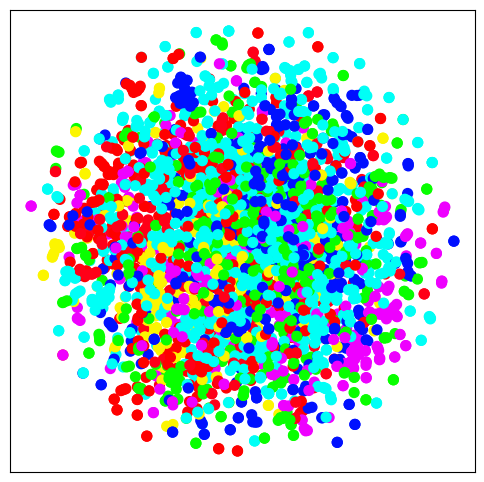

In [14]:
visualize_embedding(embedding, labels_true)

## To do

We now train the GNN.

* Train the GNN with 50% / 50% train / test split.
* Give the accuracy of the classification on the train and test sets. 
* Give the total number of parameters.
* Display the embedding provided by the hidden layer.

In [15]:
# train / test split
train_ratio = 0.5
labels = labels_true.copy()
train_mask = np.random.random(size=len(labels)) < train_ratio
test_mask = ~train_mask
labels[test_mask] = -1

In [16]:
gnn.fit(adjacency, features, labels)

In epoch   0, loss: 2.022, train accuracy: 0.114
In epoch  10, loss: 1.680, train accuracy: 0.522
In epoch  20, loss: 1.505, train accuracy: 0.780
In epoch  30, loss: 1.369, train accuracy: 0.888
In epoch  40, loss: 1.286, train accuracy: 0.931
In epoch  50, loss: 1.247, train accuracy: 0.954
In epoch  60, loss: 1.224, train accuracy: 0.967
In epoch  70, loss: 1.208, train accuracy: 0.971
In epoch  80, loss: 1.197, train accuracy: 0.979
In epoch  90, loss: 1.191, train accuracy: 0.987


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [17]:
labels_pred = gnn.predict()

In [18]:
# accuracy on train and test sets
train_acc = get_accuracy_score(labels_true[train_mask], labels_pred[train_mask]) 
test_acc = get_accuracy_score(labels_true[test_mask], labels_pred[test_mask])
print(f'Train accuracy: {train_acc:.3f}')
print(f'Test accuracy: {test_acc:.3f}')

Train accuracy: 0.987
Test accuracy: 0.805


In [19]:
# parameters
input_dim = features.shape[1]  # input features dim

# first layer (input_dim x hidden_dim) + bias (same as hidden_dim)
n_params_1 = input_dim * hidden_dim + hidden_dim

# second layer (hidden_dim x n_labels) + bias (same as n_labels)
n_params_2 = hidden_dim * n_labels + n_labels

# total
n_params = n_params_1 + n_params_2
print(f'Number of parameters: {n_params}')


Number of parameters: 23063


Computing TSNE...


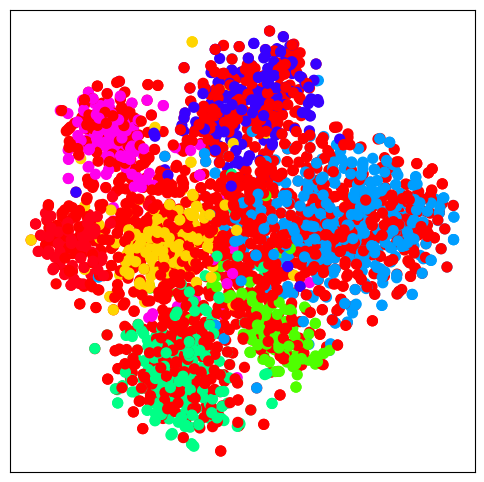

In [20]:
# display embedding from hidden layer
embedding = gnn.layers[0].embedding
visualize_embedding(embedding, labels)

## To do

* Retrain the GNN with an empty graph.
* Compare the accuracy of the classification with that of the previous model. 
* Comment the results. <br>What is the learning model?

In [21]:
empty = sparse.csr_matrix(adjacency.shape)

In [22]:
# retrain on empty 
gnn.fit(empty, features, labels)

In epoch   0, loss: 1.369, train accuracy: 0.872
In epoch  10, loss: 1.247, train accuracy: 0.974
In epoch  20, loss: 1.203, train accuracy: 0.991
In epoch  30, loss: 1.187, train accuracy: 0.995
In epoch  40, loss: 1.179, train accuracy: 0.998
In epoch  50, loss: 1.175, train accuracy: 0.998
In epoch  60, loss: 1.173, train accuracy: 0.998
In epoch  70, loss: 1.172, train accuracy: 0.999
In epoch  80, loss: 1.171, train accuracy: 0.999
In epoch  90, loss: 1.171, train accuracy: 0.999


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [23]:
labels_pred = gnn.predict()

In [24]:
train_acc_empty = get_accuracy_score(labels_true[train_mask], labels_pred[train_mask])
test_acc_empty = get_accuracy_score(labels_true[test_mask], labels_pred[test_mask])

print(f'Train accuracy')
print(f'On empty: {train_acc_empty:.3f} \t On full: {train_acc:.3f}')

print(f'Test accuracy')
print(f'On empty: {test_acc_empty:.3f} \t On full: {test_acc:.3f}')

Train accuracy
On empty: 0.999 	 On full: 0.987
Test accuracy
On empty: 0.660 	 On full: 0.805


**Answer**: The model is overfitting the trainning set, as we can see its accuracy get closer to 1 during training.

## To do

We now consider a hidden layer of dimension 32.

* Retrain the GNN (with the graph).
* Give the accuracy of the classification and the number of parameters.
* Comment the results.

In [25]:
# changing dimension
hidden_dim_32 = 32
gnn_32 = GNNClassifier(dims=[hidden_dim_32, n_labels], verbose=True)
gnn_32

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 32, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

Computing TSNE...


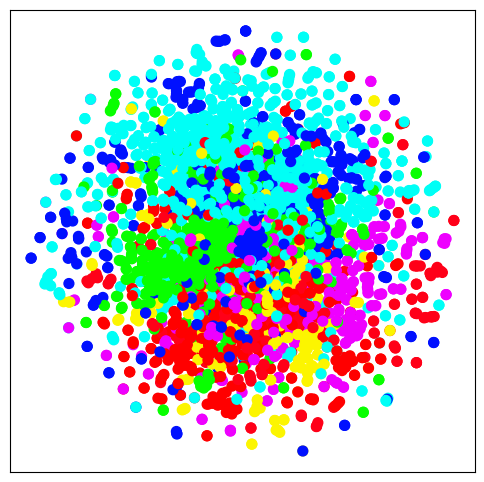

In [26]:
output_32 = gnn_32.forward(adjacency, features)
embedding_32 = gnn_32.layers[0].embedding
visualize_embedding(embedding_32, labels_true)

In [27]:
# training
gnn_32.fit(adjacency, features, labels)

In epoch   0, loss: 2.004, train accuracy: 0.134
In epoch  10, loss: 1.485, train accuracy: 0.789
In epoch  20, loss: 1.285, train accuracy: 0.943
In epoch  30, loss: 1.217, train accuracy: 0.974
In epoch  40, loss: 1.193, train accuracy: 0.986
In epoch  50, loss: 1.182, train accuracy: 0.995
In epoch  60, loss: 1.175, train accuracy: 0.998
In epoch  70, loss: 1.172, train accuracy: 0.998
In epoch  80, loss: 1.170, train accuracy: 0.998
In epoch  90, loss: 1.169, train accuracy: 0.998


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 32, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [28]:
labels_pred_32 = gnn_32.predict()

In [29]:
train_acc_32 = get_accuracy_score(labels_true[train_mask], labels_pred_32[train_mask]) 
test_acc_32 = get_accuracy_score(labels_true[test_mask], labels_pred_32[test_mask])
# print(f'Train accuracy: {train_acc_32:.3f}')
# print(f'Test accuracy: {test_acc_32:.3f}')

print(f'Train accuracy')
print(f'16: {train_acc:.3f} \t32: {train_acc_32:.3f}')

print(f'Test accuracy')
print(f'16: {test_acc:.3f} \t32: {test_acc_32:.3f}')

Train accuracy
16: 0.987 	32: 0.998
Test accuracy
16: 0.805 	32: 0.834


In [30]:
# parameters
n_params_32 = hidden_dim_32 * (features.shape[1] + 1) + n_labels * (hidden_dim_32 + 1)
print(f'Number of parameters: {n_params_32}')

Number of parameters: 46119


**Answer**: We can see that increasing the hidden dimension from 16 to 32 slightly improves the accuracy on both train and test sets. However, The number of parameters also increases.

## To do

Finally , we take 2 hidden layers, each of dimension 16.

* Retrain the GNN.
* Give the accuracy of the classification and the number of parameters.
* Comment the results.

In [31]:
# 2 hidden layers of dim 16
gnn_2 = GNNClassifier(dims=[hidden_dim, hidden_dim, n_labels], verbose=True)
gnn_2


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

Computing TSNE...


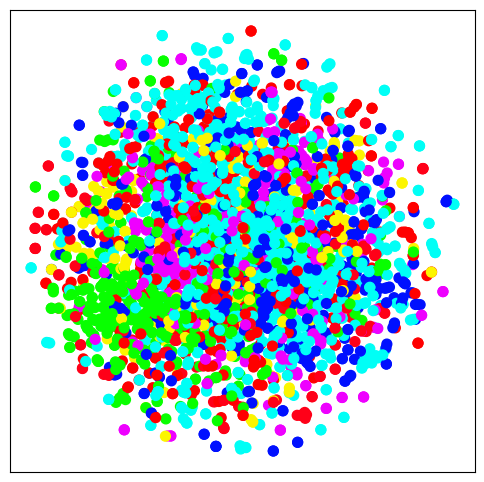

In [32]:
output_2 = gnn_2.forward(adjacency, features)
embedding_2 = gnn_2.layers[0].embedding
visualize_embedding(embedding_2, labels_true)

In [33]:
# training
gnn_2.fit(adjacency, features, labels)

In epoch   0, loss: 1.870, train accuracy: 0.291
In epoch  10, loss: 1.743, train accuracy: 0.463
In epoch  20, loss: 1.627, train accuracy: 0.665
In epoch  30, loss: 1.500, train accuracy: 0.796
In epoch  40, loss: 1.383, train accuracy: 0.867
In epoch  50, loss: 1.302, train accuracy: 0.913
In epoch  60, loss: 1.259, train accuracy: 0.938
In epoch  70, loss: 1.234, train accuracy: 0.954
In epoch  80, loss: 1.218, train accuracy: 0.964
In epoch  90, loss: 1.206, train accuracy: 0.975


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [34]:
labels_pred_2 = gnn_2.predict()

In [35]:
train_acc_2 = get_accuracy_score(labels_true[train_mask], labels_pred_2[train_mask])
test_acc_2 = get_accuracy_score(labels_true[test_mask], labels_pred_2[test_mask])

print(f'Train accuracy')
print(f'16: {train_acc_2:.3f} \t16(single layer):{train_acc:.3f} \t32: {train_acc_32:.3f}')

print(f'Test accuracy')
print(f'16: {test_acc_2:.3f} \t16(single layer):{test_acc:.3f} \t32: {test_acc_32:.3f}')

Train accuracy
16: 0.980 	16(single layer):0.987 	32: 0.998
Test accuracy
16: 0.805 	16(single layer):0.805 	32: 0.834


In [36]:
# parameters
# since both layers have the same dimension, we have:
n_params_2 = hidden_dim * (features.shape[1] + 1) + hidden_dim * (hidden_dim + 1) + n_labels * (hidden_dim + 1)
print(f'Number of parameters: {n_params_2}')

Number of parameters: 23335


**Answer**: This version needs less parameters than the `hidden_dim = 32` version, but just a few more than the single layer `hidden_dim = 16` model. Regarding the accuracy, it does not improve the performance of the `hidden_dim = 32` version.

## 2. Wikivitals

We now focus on Wikivitals. We take the spectral embedding of the article-word bipartite graph as features.

In [37]:
dataset_WV = wikivitals

In [38]:
adjacency_WV = dataset_WV.adjacency
biadjacency_WV = dataset_WV.biadjacency
names_WV = dataset_WV.names
labels_true_WV = dataset_WV.labels
names_labels_WV = dataset_WV.names_labels

In [39]:
# we consider the graph as undirected
adjacency_WV = directed2undirected(adjacency_WV)

In [40]:
# we use the spectral embedding of the bipartite graph as features
spectral = Spectral(20)
features_WV = spectral.fit_transform(biadjacency_WV)

## To do

We consider a GNN with a single hidden layer of dimension 16.
* Train the GNN with 50% / 50% train / test split.
* Give the accuracy of the classification.
* Display the confusion matrix of the test set.
* Give for each label the 5 articles of the test set classified with the highest confidence.

In [41]:
n_labels_WV = len(set(labels_true_WV))

In [42]:
print(set(labels_true_WV))
print(np.unique(labels_true_WV))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)}
[ 0  1  2  3  4  5  6  7  8  9 10]


In [43]:
gnn_WV = GNNClassifier(dims=[hidden_dim, n_labels_WV], verbose=True)

In [44]:
# train / test split
train_ratio = 0.5
labels_WV = labels_true_WV.copy()
train_mask = np.random.random(size=len(labels_WV)) < train_ratio
test_mask = ~train_mask
labels_WV[test_mask] = -1

In [45]:
gnn_WV.fit(adjacency_WV, features_WV, labels_WV)

In epoch   0, loss: 2.375, train accuracy: 0.174
In epoch  10, loss: 2.263, train accuracy: 0.447
In epoch  20, loss: 2.108, train accuracy: 0.649
In epoch  30, loss: 1.976, train accuracy: 0.730
In epoch  40, loss: 1.890, train accuracy: 0.770
In epoch  50, loss: 1.843, train accuracy: 0.788
In epoch  60, loss: 1.819, train accuracy: 0.797
In epoch  70, loss: 1.805, train accuracy: 0.808
In epoch  80, loss: 1.796, train accuracy: 0.813
In epoch  90, loss: 1.789, train accuracy: 0.820


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 11, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [46]:
labels_pred_WV = gnn_WV.predict()

train_acc_WV = get_accuracy_score(labels_true_WV[train_mask], labels_pred_WV[train_mask])
test_acc_WV = get_accuracy_score(labels_true_WV[test_mask], labels_pred_WV[test_mask])

print(f'WikiVitals train accuracy: {train_acc_WV:.4f}')
print(f'WikiVitals test accuracy: {test_acc_WV:.4f}')

WikiVitals train accuracy: 0.8269
WikiVitals test accuracy: 0.8081


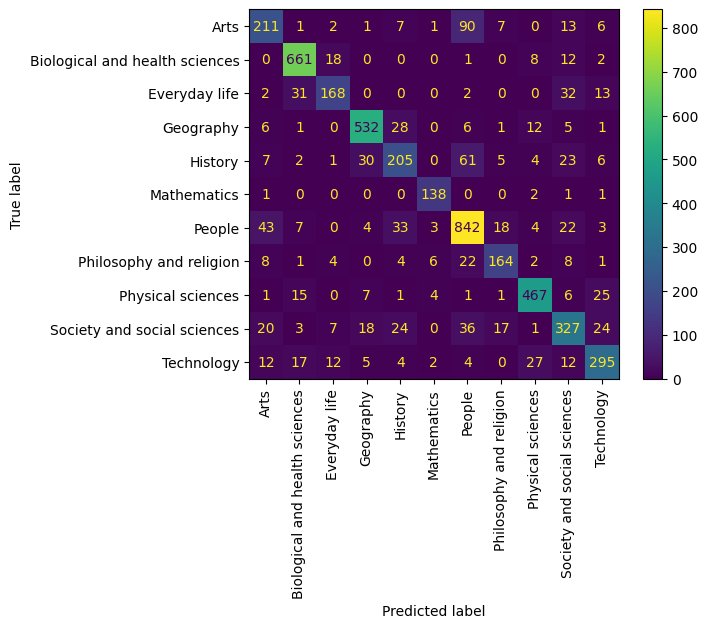

In [47]:
valid_labels = np.arange(len(names_labels_WV)) 

confusion_matrix = metrics.confusion_matrix(labels_true_WV[test_mask], labels_pred_WV[test_mask], labels=valid_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=names_labels_WV)

cm_display.plot()
plt.xticks(rotation=90, ha='center')
plt.show()

In [48]:

probs = gnn_WV.predict_proba()

for i, name in enumerate(names_labels_WV):

    predicted = (labels_pred_WV[test_mask] == i)
    if predicted.sum() > 0:
 
        confidences = probs[test_mask][predicted, i]

        article_indices = np.where(test_mask)[0][predicted]

        top5_idx = np.argsort(confidences)[-5:][::-1]
        print(f"\nLabel {name} - Top 5 articles:")
        for i, idx in enumerate(top5_idx):
            if i < len(article_indices):
                article_name = names_WV[article_indices[idx]]
                confidence = confidences[idx]
                print(f"  {article_name}: {confidence:.3f}")


Label Arts - Top 5 articles:
  Painting: 0.996
  Visual arts: 0.995
  Metropolitan Museum of Art: 0.993
  Theatre: 0.992
  Art Nouveau: 0.990

Label Biological and health sciences - Top 5 articles:
  Mammal: 1.000
  Plant: 1.000
  Triassic: 1.000
  Lung: 1.000
  Permian: 1.000

Label Everyday life - Top 5 articles:
  Gymnastics: 0.997
  Water polo: 0.995
  Bowling: 0.992
  Handball: 0.992
  Bowls: 0.989

Label Geography - Top 5 articles:
  Geographic coordinate system: 1.000
  Köppen climate classification: 1.000
  Time zone: 1.000
  Indian Ocean: 1.000
  Southern Cone: 1.000

Label History - Top 5 articles:
  Kievan Rus': 0.972
  Vandals: 0.960
  Goths: 0.958
  Huns: 0.954
  Carolingian Empire: 0.948

Label Mathematics - Top 5 articles:
  Function (mathematics): 0.999
  Real number: 0.999
  Integer: 0.999
  Category theory: 0.999
  Random variable: 0.998

Label People - Top 5 articles:
  Winston Churchill: 1.000
  Mikhail Sholokhov: 1.000
  Ronald Reagan: 1.000
  Richard Nixon: 1.000

## To do

Compare the results with those obtained with:
* Heat diffusion on the graph.
* Logistic regression on the features.

In [ ]:
# heat diffusion
from sknetwork.classification import DiffusionClassifier
diffusion = DiffusionClassifier()
labels_pred_diffusion = diffusion.fit_predict(adjacency_WV, labels_WV)

# accuracy
train_acc_diffusion = get_accuracy_score(labels_true_WV[train_mask], labels_pred_diffusion[train_mask])
test_acc_diffusion = get_accuracy_score(labels_true_WV[test_mask], labels_pred_diffusion[test_mask])

# compare
print(f'Train accuracy')
print(f'GNN: {train_acc_WV:.3f} \tDiffusion: {train_acc_diffusion:.3f}')

print(f'Test accuracy')
print(f'GNN: {test_acc_WV:.3f} \tDiffusion: {test_acc_diffusion:.3f}')

Train accuracy
GNN: 0.827 	Diffusion: 1.000
Test accuracy
GNN: 0.808 	Diffusion: 0.737


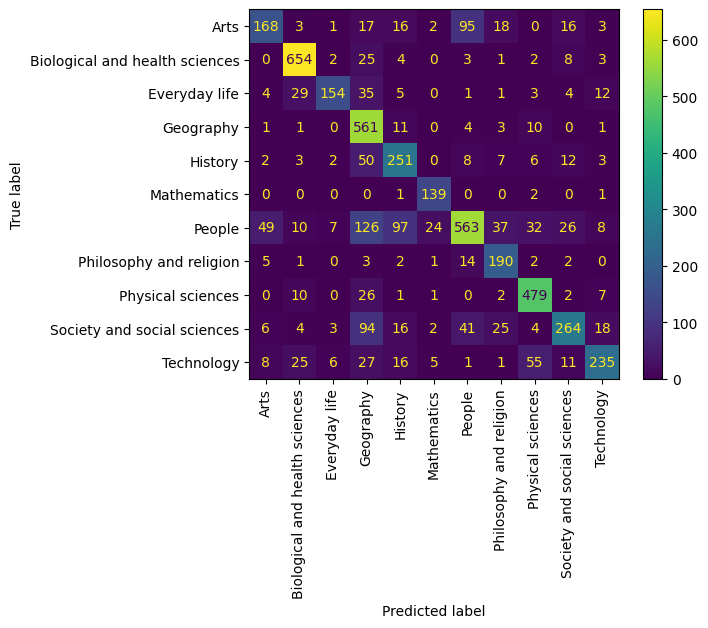

In [51]:
# confusion matrix
valid_labels = np.arange(len(names_labels_WV)) 

confusion_matrix = metrics.confusion_matrix(labels_true_WV[test_mask], labels_pred_diffusion[test_mask], labels=valid_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=names_labels_WV)

cm_display.plot()
plt.xticks(rotation=90, ha='center')
plt.show()

In [55]:
# logistic regression
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression().fit(features_WV[train_mask], labels_WV[train_mask])
labels_pred_logistic = logistic.predict(features_WV)

# accuracy
train_acc_diffusion = get_accuracy_score(labels_true_WV[train_mask], labels_pred_logistic[train_mask])
test_acc_logistic = get_accuracy_score(labels_true_WV[test_mask], labels_pred_logistic[test_mask])

# compare
print(f'Train accuracy')
print(f'GNN: {train_acc_WV:.3f} \tDiffusion: {train_acc_diffusion:.3f} \tLogistic: {train_acc_diffusion:.3f}')

print(f'Test accuracy')
print(f'GNN: {test_acc_WV:.3f} \tDiffusion: {test_acc_diffusion:.3f} \tLogistic: {test_acc_logistic:.3f}')

Train accuracy
GNN: 0.827 	Diffusion: 0.813 	Logistic: 0.813
Test accuracy
GNN: 0.808 	Diffusion: 0.737 	Logistic: 0.802


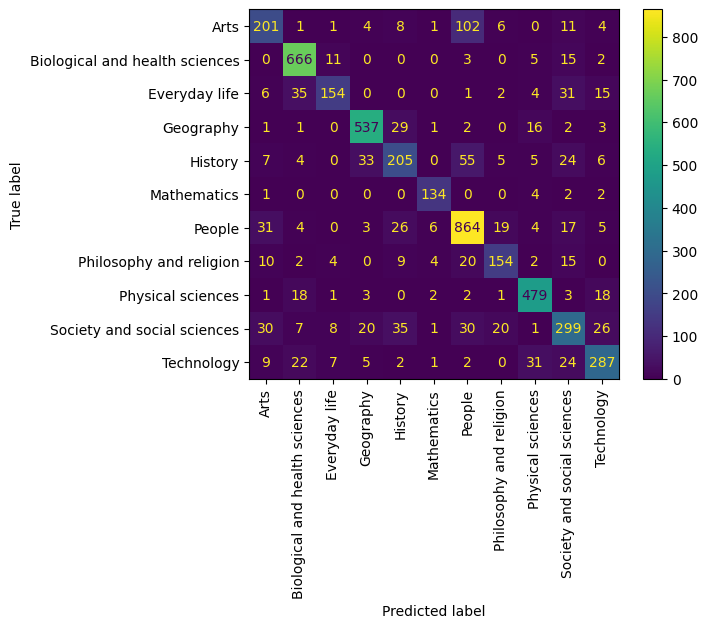

In [56]:
# confusion matrix
valid_labels = np.arange(len(names_labels_WV)) 

confusion_matrix = metrics.confusion_matrix(labels_true_WV[test_mask], labels_pred_logistic[test_mask], labels=valid_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=names_labels_WV)

cm_display.plot()
plt.xticks(rotation=90, ha='center')
plt.show()